Data access for Peripheral Ice Caps.  This particular version collects ATL06 data for Renland Ice Cap in eastern Greenland.  I use the same approach with a different bounding box for the other icecaps in my proposal.  

Based _very heavily_ on: 

1) Amy Steiker's tutorial from the UW Hackweek, found at https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/blob/master/03_NSIDCDataAccess_Steiker/NSIDC%20DAAC%20ICESat-2%20Customize%20and%20Access.ipynb

2) Fernando Paolo's tutorial on reducing IS2 files, found at https://github.com/ICESAT-2HackWeek/intro-hdf5/blob/master/notebooks/redu-is2-files.ipynb

This finds, subsets, downloads, and then further subsets the data, and exports it to a csv file we can bring easily into QGIS for visualization on the proposal.   

In [6]:
# Probably don't need _all_ of these modules, but it doesn't hurt
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
# import pprint
import time
# import geopandas as gpd
# import matplotlib.pyplot as plt
import fiona
import h5py
import re
# import contextily as ctx
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
# fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
# from shapely.geometry import Polygon, mapping
# from shapely.geometry.polygon import orient
# from statistics import mean
from requests.auth import HTTPBasicAuth

Now that we've gotten all of the modules loaded, get the EarthData token set up.  

In [7]:
# Earthdata Login credentials

# Enter your Earthdata Login user name
uid = 'robertlhawley'
# Enter your email address associated with your Earthdata Login account
email = 'robert.l.hawley@dartmouth.edu'
pswd = getpass.getpass('Earthdata Login password: ')

Earthdata Login password: ········


In [14]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
ip = socket.gethostbyname('localhost')

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)

961DE005-5855-FC01-004E-22B150581FA3


In [15]:
# Input data set ID (e.g. ATL06) of interest here, also known as "short name".

short_name = 'ATL06'

In [20]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

search_params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=search_params)
results = json.loads(response.content)
# pprint.pprint(results)

In [22]:
# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
# print(latest_version)

In [16]:
# Input temporal range 

# Input start date in yyyy-MM-dd format
start_date = '2019-02-22'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-09-29'
# Input end time in HH:mm:ss format
end_time = '23:59:59'

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2019-02-22T00:00:00Z,2019-09-29T23:59:59Z


In [17]:
# Bounding Box spatial parameter in 'W,S,E,N' format

# Input bounding box
# Input lower left longitude in decimal degrees
LL_lon = '-28' # For Renland.  For NIC, '-69'
# Input lower left latitude in decimal degrees
LL_lat = '71' # For Renland.  For NIC,'76.6'
# Input upper right longitude in decimal degrees
UR_lon = '-25.5' # For Renland.  For NIC,'-67'
# Input upper right latitude in decimal degrees
UR_lat = '71.5' # For Renland.  For NIC,'77.2'

bounding_box = LL_lon + ',' + LL_lat + ',' + UR_lon + ',' + UR_lat
# aoi value used for CMR params below
aoi = '1'
print(bounding_box)

-28,71,-25.5,71.5


In [23]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

# print('CMR search parameters: ', search_params)

In [24]:
# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)

21

In [26]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

print(capability_url)

https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL06.001.xml


In [27]:
# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

In [28]:
# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

In [29]:
# Bounding box subsetting (bbox) in same format as bounding_box

bbox = bounding_box

In [30]:
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time
print(timevar)

2019-02-22T00:00:00,2019-09-29T23:59:59


Seems like the 'coverage' variable below is the list of (subset) of variables we want in our HDF5 file when we download it from NSIDC.  Can reduce or expand depending on what we want in the end.  

In [31]:
coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
/gt1l/land_ice_segments/atl06_quality_summary,\
/gt1l/land_ice_segments/delta_time,\
/gt1l/land_ice_segments/h_li,\
/gt1l/land_ice_segments/h_li_sigma,\
/gt1l/land_ice_segments/latitude,\
/gt1l/land_ice_segments/longitude,\
/gt1l/land_ice_segments/segment_id,\
/gt1l/land_ice_segments/sigma_geo_h,\
/gt1r/land_ice_segments/atl06_quality_summary,\
/gt1r/land_ice_segments/delta_time,\
/gt1r/land_ice_segments/h_li,\
/gt1r/land_ice_segments/h_li_sigma,\
/gt1r/land_ice_segments/latitude,\
/gt1r/land_ice_segments/longitude,\
/gt1r/land_ice_segments/segment_id,\
/gt1r/land_ice_segments/sigma_geo_h,\
/gt2l/land_ice_segments/atl06_quality_summary,\
/gt2l/land_ice_segments/delta_time,\
/gt2l/land_ice_segments/h_li,\
/gt2l/land_ice_segments/h_li_sigma,\
/gt2l/land_ice_segments/latitude,\
/gt2l/land_ice_segments/longitude,\
/gt2l/land_ice_segments/segment_id,\
/gt2l/land_ice_segments/sigma_geo_h,\
/gt2r/land_ice_segments/atl06_quality_summary,\
/gt2r/land_ice_segments/delta_time,\
/gt2r/land_ice_segments/h_li,\
/gt2r/land_ice_segments/h_li_sigma,\
/gt2r/land_ice_segments/latitude,\
/gt2r/land_ice_segments/longitude,\
/gt2r/land_ice_segments/segment_id,\
/gt2r/land_ice_segments/sigma_geo_h,\
/gt3l/land_ice_segments/atl06_quality_summary,\
/gt3l/land_ice_segments/delta_time,\
/gt3l/land_ice_segments/h_li,\
/gt3l/land_ice_segments/h_li_sigma,\
/gt3l/land_ice_segments/latitude,\
/gt3l/land_ice_segments/longitude,\
/gt3l/land_ice_segments/segment_id,\
/gt3l/land_ice_segments/sigma_geo_h,\
/gt3r/land_ice_segments/atl06_quality_summary,\
/gt3r/land_ice_segments/delta_time,\
/gt3r/land_ice_segments/h_li,\
/gt3r/land_ice_segments/h_li_sigma,\
/gt3r/land_ice_segments/latitude,\
/gt3r/land_ice_segments/longitude,\
/gt3r/land_ice_segments/segment_id,\
/gt3r/land_ice_segments/sigma_geo_h,\
/orbit_info/cycle_number,\
/orbit_info/rgt,\
/orbit_info/orbit_number'

In [32]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

In [33]:
# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

#Create config dictionary
config_params = {
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email,   
}

# Determine how many individual orders we will request based on the number of granules requested

print(page_num)

3


In [34]:
# Adding customization parameter dictionary 

custom_params = {
    'time': timevar,
    'Coverage': coverage,
}

# Creating final request parameter dictionary with search, config, and customization parameters.

subset_request_params = {**search_params, **config_params, **custom_params}

# print(subset_request_params)

In [35]:
path = str('/bigtmp/Renland_ATLAS')
if not os.path.exists(path):
    os.mkdir(path)

In [36]:
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    subset_request_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

#     shape_post = {'shapefile': open(kml_filepath, 'rb')}
#     request = session.post(base_url, params=subset_request_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
    request = session.get(base_url, params=subset_request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-22T00%3A00%3A00Z%2C2019-09-29T23%3A59%3A59Z&page_size=10&page_num=1&bounding_box=-28%2C71%2C-25.5%2C71.5&request_mode=async&token=961DE005-5855-FC01-004E-22B150581FA3&email=robert.l.hawley%40dartmouth.edu&time=2019-02-22T00%3A00%3A00%2C2019-09-29T23%3A59%3A59&Coverage=%2Fancillary_data%2Fatlas_sdp_gps_epoch%2C%2Fgt1l%2Fland_ice_segments%2Fatl06_quality_summary%2C%2Fgt1l%2Fland_ice_segments%2Fdelta_time%2C%2Fgt1l%2Fland_ice_segments%2Fh_li%2C%2Fgt1l%2Fland_ice_segments%2Fh_li_sigma%2C%2Fgt1l%2Fland_ice_segments%2Flatitude%2C%2Fgt1l%2Fland_ice_segments%2Flongitude%2C%2Fgt1l%2Fland_ice_segments%2Fsegment_id%2C%2Fgt1l%2Fland_ice_segments%2Fsigma_geo_h%2C%2Fgt1r%2Fland_ice_segments%2Fatl06_quality_summary%2C%2Fgt1r%2Fland_ice_segments%2Fdelta_time%2C%2Fgt1r%2Fland_ice_segments%2Fh_li%2C%2Fgt1r%2Fland_ice_segments%2Fh_li_sigma%2C%2Fgt1r%2Fland_ice

Retry request status is:  pending
Status is not complete. Trying again.
Retry request status is:  pending
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  complete
Zip download URL:  https://n5eil02u.ecs.nsidc.org/esir/5000000388803.zip
Beginning download of zipped output...
Data request 2 is complete.
Order:  3
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-22T00%3A00%3A00Z%2C2019-09-29T23%3A59%3A59Z&page_size=10&page_num=3&bounding_box=-28%2C71%2C-25.5%2C71.5&request_mode=async&token=961DE005-5855-FC01-004E-22B150581FA3&email=robert.l.hawley%40dartmouth.edu&time=2019-02-22T00%3A00%3A00%

In [37]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [38]:
#List files
sorted(os.listdir(path))

['processed_ATL06_20190225103615_09010203_001_02.h5',
 'processed_ATL06_20190225232108_09090205_001_02.h5',
 'processed_ATL06_20190301231249_09700205_001_02.h5',
 'processed_ATL06_20190314093716_11600203_001_02.h5',
 'processed_ATL06_20190314222209_11680205_001_02.h5',
 'processed_ATL06_20190318092856_12210203_001_02.h5',
 'processed_ATL06_20190318221349_12290205_001_02.h5',
 'processed_ATL06_20190322092035_12820203_001_02.h5',
 'processed_ATL06_20190322220528_12900205_001_02.h5',
 'processed_ATL06_20190326091214_13430203_001_02.h5',
 'processed_ATL06_20190326215707_13510205_001_02.h5',
 'processed_ATL06_20190330214848_00250305_001_01.h5',
 'processed_ATL06_20190412081315_02150303_001_01.h5',
 'processed_ATL06_20190416080454_02760303_001_01.h5',
 'processed_ATL06_20190416204947_02840305_001_01.h5',
 'processed_ATL06_20190420075634_03370303_001_01.h5',
 'processed_ATL06_20190420204127_03450305_001_01.h5',
 'processed_ATL06_20190424074814_03980303_001_01.h5',
 'processed_ATL06_2019042420

In [39]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear


def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors

In [40]:
import h5py
import numpy as np

def read_atl06(fname, bbox):
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            lat = fi[g+'/land_ice_segments/latitude'][:]
            lon = fi[g+'/land_ice_segments/longitude'][:]
            h_li = fi[g+'/land_ice_segments/h_li'][:]
            s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
            t_dt = fi[g+'/land_ice_segments/delta_time'][:]
            q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
            orb = np.full_like(h_li, k)

        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            
        # Only keep good data, and data inside bbox
        mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1)
        
        # Update variables        
        lat, lon, h_li, s_li, t_dt, q_flag, \
             rgt, orb = \
                lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask], \
                q_flag[mask],  \
                rgt[mask], orb[mask]
        

        # Test for no data
        if len(h_li) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde 1980...)
        t_gps = t_ref + t_dt

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_li
            f['t_year'] = t_year
            f['t_sec'] = t_gps
            f['s_elv'] = s_li
            f['q_flg'] = q_flag
            f['rgt'] = rgt
            f['trk_type'] = i_asc

            print('out ->', ofile)

In [42]:
njobs = 3

def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)

files = list_files_local('/bigtmp/Renland_ATLAS/processed*.h5')
print(files)

# bbox = None #[-1124782, 81623, -919821, -96334]
bbox = -28.1,-25.5,71,71.5

if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, bbox) for f in files)

['/bigtmp/Renland_ATLAS/processed_ATL06_20190322220528_12900205_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190416080454_02760303_001_01.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190314222209_11680205_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190428202447_04670305_001_01.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190326215707_13510205_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190322092035_12820203_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190326091214_13430203_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190314093716_11600203_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190225232108_09090205_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190424203307_04060305_001_01.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190420204127_03450305_001_01.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190225103615_09010203_001_02.h5', '/bigtmp/Renland_ATLAS/processed_ATL06_20190301231249_09700205_001_02.h5', '/bigtmp/Renland_ATLAS/p

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:    1.4s finished


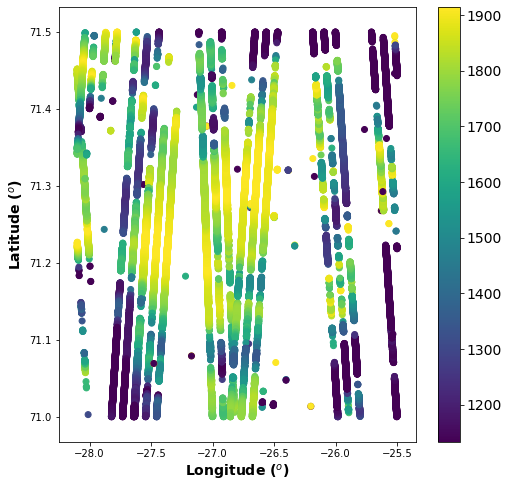

In [44]:
import matplotlib.pyplot as plt

def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)

def read_h5(fname, vnames=[]):
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]
    
files = list_files_local('/bigtmp/Renland_ATLAS/processed_ATL06_20190*gt*.h5')

fig = plt.figure(figsize=(8,8))


for fname in files:

    lon, lat, t, h = read_h5(fname, ['lon', 'lat', 't_year', 'h_elv'])
    
    # Plot to see what it looks like
    plt.scatter(lon, lat, c=h)
    # This line saves the lat/lon/elevation in a CSV file so we can easily bring it into QGIS 
    # for more context and tweaks for a figure
    np.savetxt(fname + '.txt',np.c_[lon, lat, h])
    
plt.rcParams.update({'font.size': 14})    
plt.xlabel('Longitude ($^o$)', fontsize=14, fontweight='bold')
plt.ylabel('Latitude ($^o$)', fontsize=14, fontweight='bold')
plt.colorbar()
plt.show()